# Raw Analytics - Austin Airbnb

Análise de qualidade dos dados brutos da camada Bronze - 12 Gráficos.

### Configuração do ambiente
- **Objetivo:** preparar ambiente visual e carregar dados.
- **Ações:** aplica tema gráfico e carrega CSVs.
- **Saída:** dataframes prontos para análise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

plt.style.use('seaborn-v0_8')
sns.set_theme(context="notebook", style="whitegrid")

### Carregamento dos dados

In [2]:
df_listings = pd.read_csv('dados_brutos_listings.csv')
df_calendar = pd.read_csv('dados_brutos_calendar.csv')
df_reviews = pd.read_csv('dados_brutos_reviews.csv')

## Gráfico 1: Gráfico de Barras - Top 10 Tipos de Propriedade

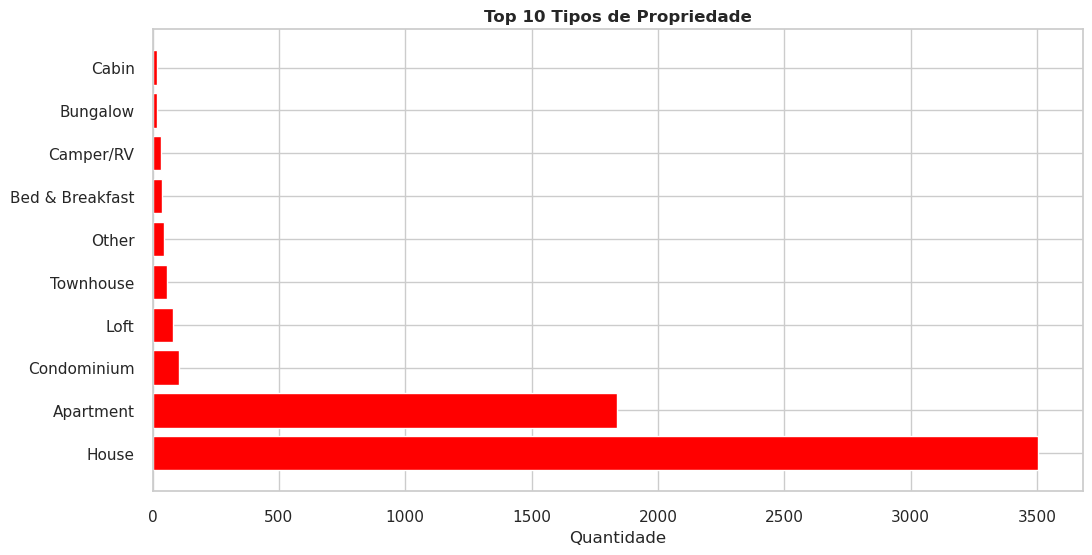

In [3]:
prop_counts = df_listings['property_type'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(prop_counts)), prop_counts.values, color='#f00')
ax.set_yticks(range(len(prop_counts)))
ax.set_yticklabels(prop_counts.index)
ax.set_xlabel('Quantidade')
ax.set_title('Top 10 Tipos de Propriedade', fontweight='bold')
plt.show()

## Gráfico 2: Gráfico de Pizza - Distribuição de Tipos de Quarto

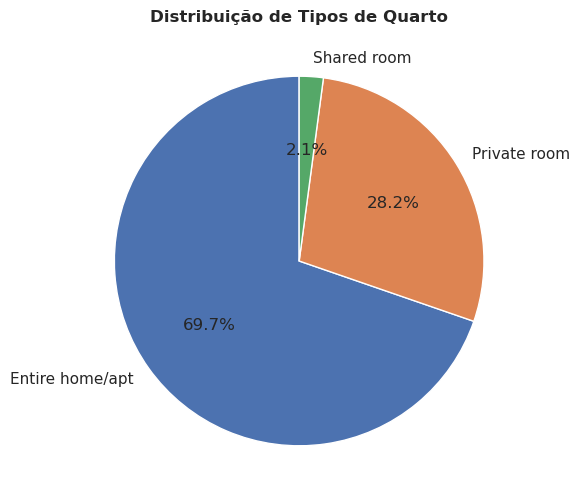

In [4]:
room_dist = df_listings['room_type'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(room_dist.values, labels=room_dist.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribuição de Tipos de Quarto', fontweight='bold')
plt.show()

## Gráfico 3: Gráfico de Barras - Disponibilidade no Calendar

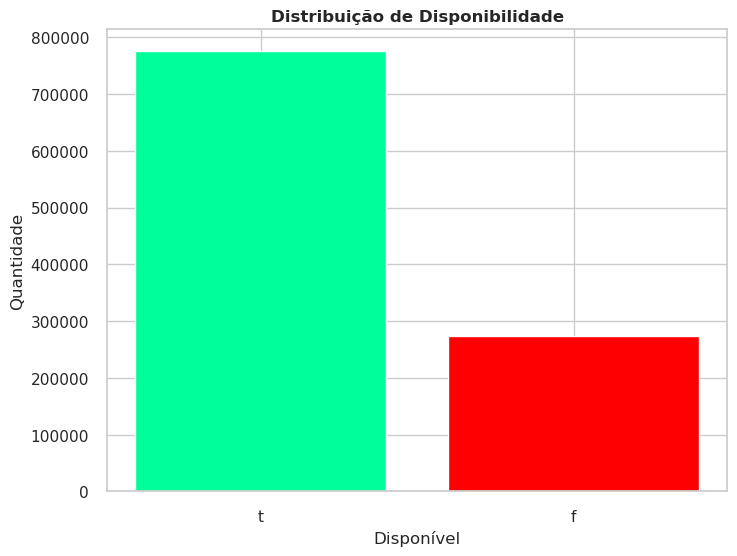

In [5]:
avail_dist = df_calendar['available'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(avail_dist.index, avail_dist.values, color=['#0f9', '#f00'])
ax.set_xlabel('Disponível')
ax.set_ylabel('Quantidade')
ax.set_title('Distribuição de Disponibilidade', fontweight='bold')
plt.show()

## Gráfico 4: Histograma - Distribuição de Preços

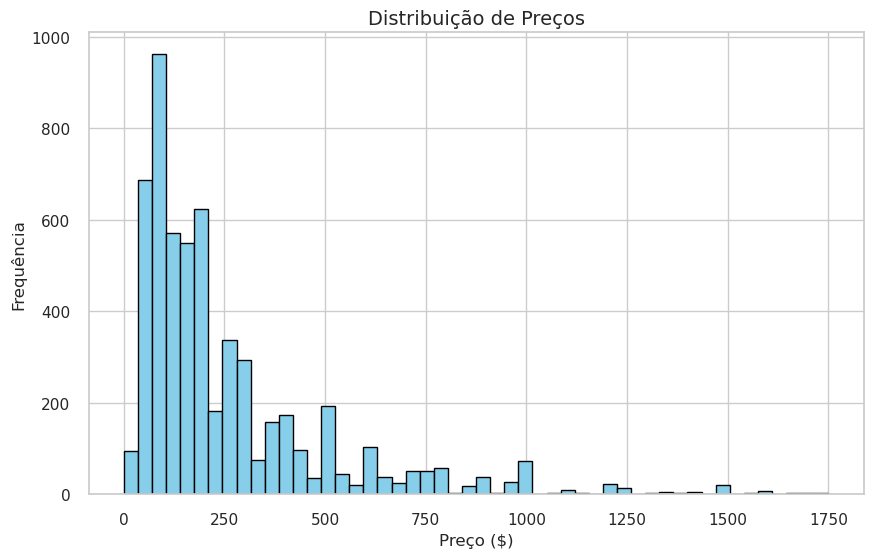

In [6]:
df_listings['price_clean'] = df_listings['price'].str.replace('$', '').str.replace(',', '').astype(float)
price_clean = df_listings['price_clean'][df_listings['price_clean'] <= df_listings['price_clean'].quantile(0.99)]

plt.figure(figsize=(10, 6))
plt.hist(price_clean, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribuição de Preços', fontsize=14)
plt.xlabel('Preço ($)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

## Gráfico 5: Gráfico de Linha - Reviews ao Longo do Tempo

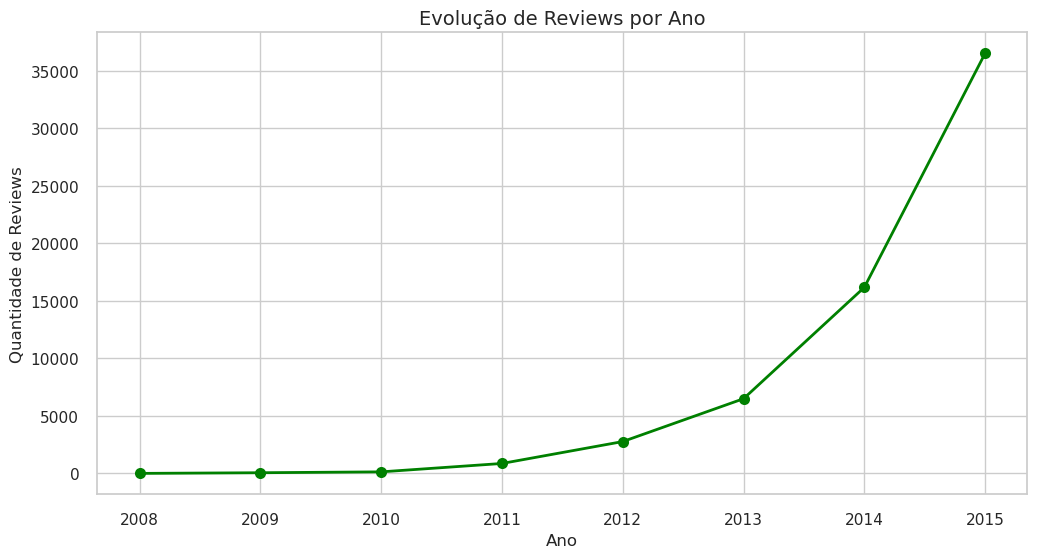

In [7]:
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_reviews['year'] = df_reviews['date'].dt.year
reviews_by_year = df_reviews['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(reviews_by_year.index, reviews_by_year.values, marker='o', color='green', linewidth=2, markersize=8)
plt.title('Evolução de Reviews por Ano', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Reviews', fontsize=12)
plt.show()

## Gráfico 6: Gráfico de Barras - Reviews por Ano

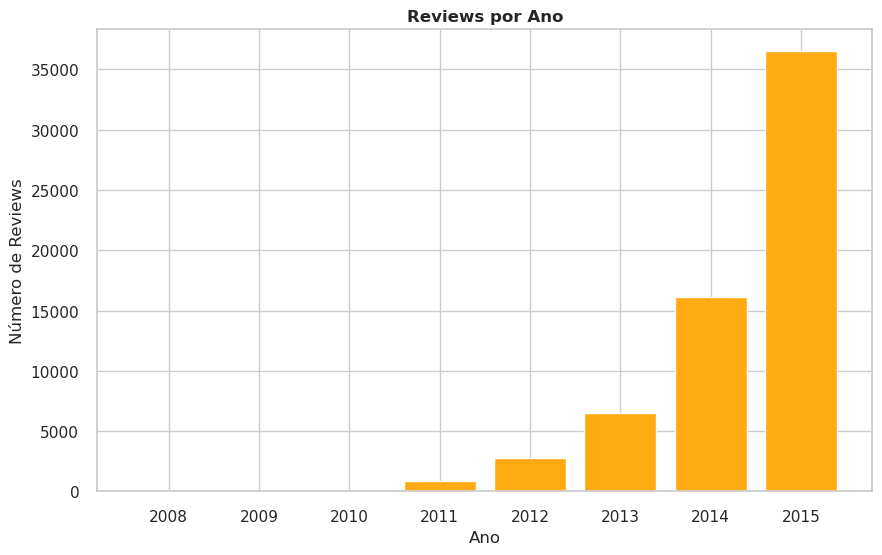

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(reviews_by_year.index, reviews_by_year.values, color='#fa1')
ax.set_xlabel('Ano')
ax.set_ylabel('Número de Reviews')
ax.set_title('Reviews por Ano', fontweight='bold')
plt.show()

## Gráfico 7: Gráfico de Barras - Top 10 Bairros

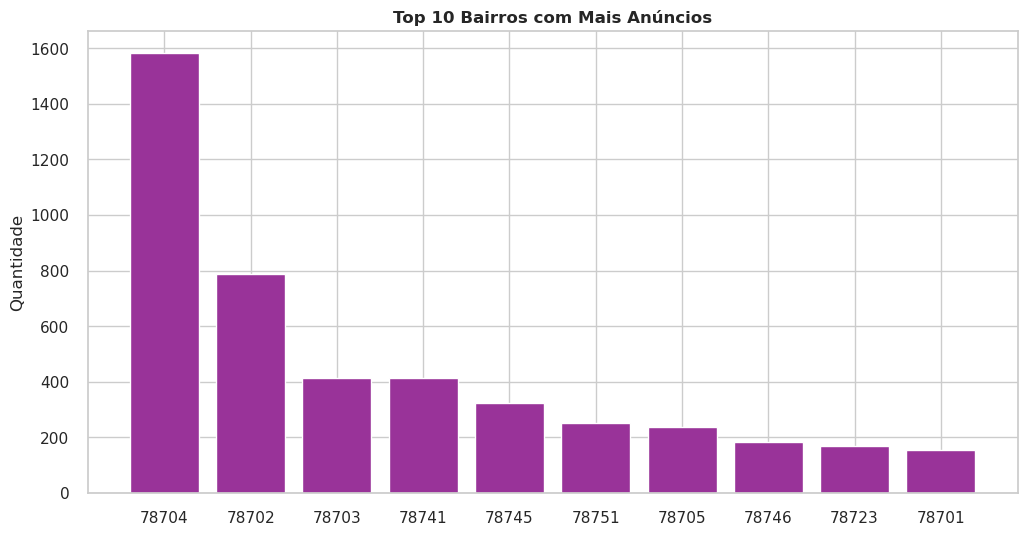

In [9]:
neigh_counts = df_listings['neighbourhood_cleansed'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(len(neigh_counts)), neigh_counts.values, color='#993399')
ax.set_xticks(range(len(neigh_counts)))
ax.set_xticklabels(neigh_counts.index)
ax.set_ylabel('Quantidade')
ax.set_title('Top 10 Bairros com Mais Anúncios', fontweight='bold')
plt.show()

## Gráfico 8: BoxPlot - Distribuição de Preços por Tipo de Quarto

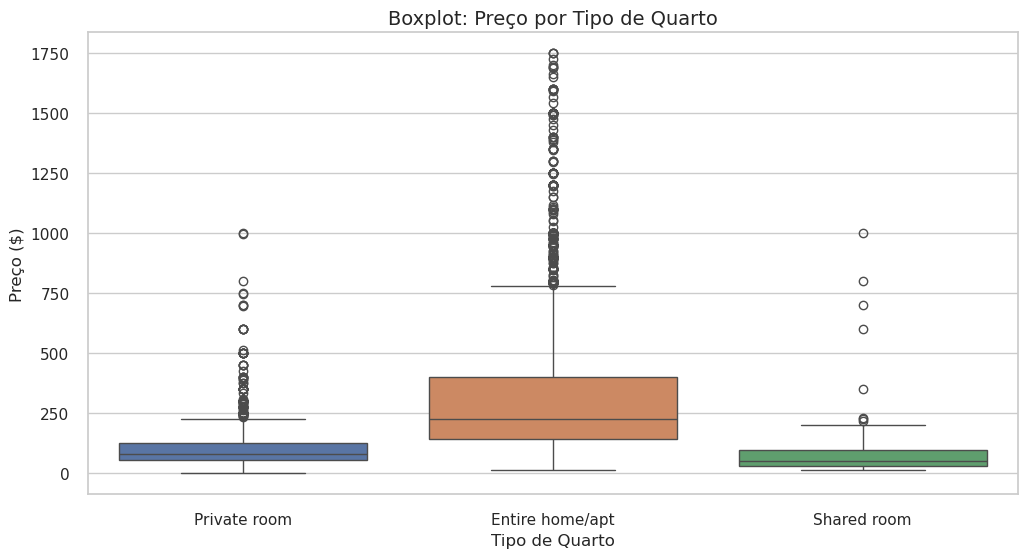

In [10]:
df_listings['price_numeric'] = df_listings['price'].str.replace('$', '').str.replace(',', '').astype(float)
price_data = df_listings[['room_type', 'price_numeric']].dropna() #se não tiver, não roda
quant99 = price_data['price_numeric'].quantile(0.99)
price_filtrado = price_data[price_data['price_numeric'] <= quant99]

plt.figure(figsize=(12, 6))
sns.boxplot(data=price_filtrado, x='room_type', y='price_numeric', hue='room_type', legend=False)
plt.title('Boxplot: Preço por Tipo de Quarto', fontsize=14)
plt.xlabel('Tipo de Quarto', fontsize=12)
plt.ylabel('Preço ($)', fontsize=12)
plt.show()

## Gráfico 9: Matriz de Confusão - Tipo de Quarto vs Faixa de Preço

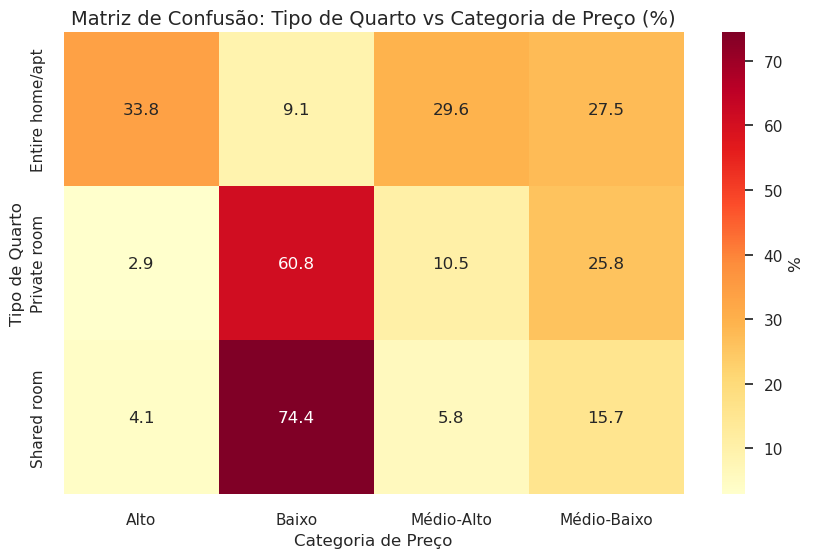

In [11]:
df_conf = df_listings[['room_type', 'price_numeric']].dropna() #precisa do dropna porque não roda sem
quartiles = df_conf['price_numeric'].quantile([0.25, 0.5, 0.75])


def categorize_price(price):
    if price <= quartiles[0.25]:
        return 'Baixo'
    elif price <= quartiles[0.5]:
        return 'Médio-Baixo'
    elif price <= quartiles[0.75]:
        return 'Médio-Alto'
    else:
        return 'Alto'

df_conf['price_category'] = df_conf['price_numeric'].apply(categorize_price)

confusion = pd.crosstab(df_conf['room_type'], df_conf['price_category'], normalize='index') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(confusion, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': '%'})
plt.title('Matriz de Confusão: Tipo de Quarto vs Categoria de Preço (%)', fontsize=14)
plt.xlabel('Categoria de Preço', fontsize=12)
plt.ylabel('Tipo de Quarto', fontsize=12)
plt.show()

## Gráfico 10: Regressão Linear - Preço vs Número de Reviews

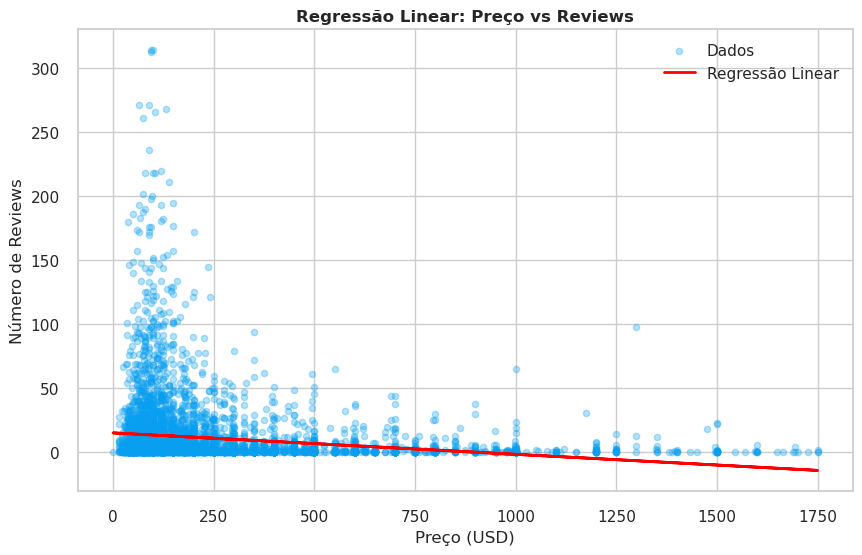

In [12]:
df_reg = df_listings[['price_numeric', 'number_of_reviews']].dropna()
df_reg = df_reg[df_reg['price_numeric'] <= df_reg['price_numeric'].quantile(0.99)]

x = df_reg[['price_numeric']]
y = df_reg['number_of_reviews']

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x) #“Quantos reviews essa reta prevê?”

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, alpha=0.3, s=20, color='#099ff0', label='Dados') #pontinhos; alpha=transparencia; s=size
ax.plot(x, y_pred, color='red', linewidth=2, label='Regressão Linear') #reta vermelha
ax.set_xlabel('Preço (USD)')
ax.set_ylabel('Número de Reviews')
ax.set_title('Regressão Linear: Preço vs Reviews', fontweight='bold')
ax.legend()
plt.show()